Задача данного проекта состоит в решении соревнования более новыми методами, появившимися после 2017 года, а так же сравнеие с уже существующими, но уставревшими методами

Для сранения выбраны следующие работы:
1. https://www.kaggle.com/code/luannoleto/vers-o-final-camera-identify
2. https://www.kaggle.com/code/CVxTz/keras-simple-cnn-starter

Сравнение будет проведено позже

Собственное решение соревенования основано на архитектуре Swin Transformers

#Настройка Kaggle

In [ ]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('/content/kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)
print("Kaggle API настроен!")

Kaggle API настроен!


In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c sp-society-camera-model-identification

100% 10.5G/10.6G [02:09<00:00, 157MB/s]
100% 10.6G/10.6G [02:09<00:00, 87.2MB/s]


In [ ]:
import zipfile

os.makedirs('/content/dataset', exist_ok=True)
with zipfile.ZipFile('/content/sp-society-camera-model-identification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')
print("Данные успешно разархивированы!")

Данные успешно разархивированы!


#Подключение библиотек, настройка устройства

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from timm import create_model
import pandas as pd
from PIL import Image
import os
import time

# Step 1: Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Обработка данных

Без аугментации

In [ ]:
""" Добавление аугментации
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])"""


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Загрузка данных

Разделим тренировочные данные на обучающую выборку и валидационную

In [ ]:
full_train_dataset = ImageFolder(root="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/train/train", transform=transform_train)
class_names = full_train_dataset.classes  # Mapping from index to class name
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for images, labels in train_loader:
    print("Batch labels:", labels.numpy())
    break

Batch labels: [1 2 5 1 3 6 5 5 8 4 1 3 0 2 8 8]


In [ ]:
pd.Series(train_dataset.dataset.targets).value_counts()

,count
0,275
1,275
2,275
3,275
4,275
5,275
6,275
7,275
8,275
9,275


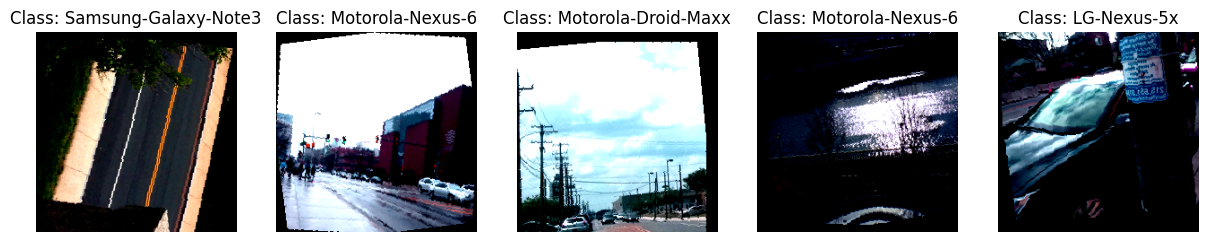

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(loader, class_names):
    images, labels = next(iter(loader))
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow((images[i] * 0.5 + 0.5))
        axes[i].set_title(f"Class: {class_names[labels[i].item()]}")
        axes[i].axis("off")
    plt.show()

show_images(train_loader, class_names)

#Обработка тестового датасета

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.data.iloc[idx, 0]

#Создание модели

In [ ]:
model = create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=len(full_train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)


#Тренировка и валидация

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        scheduler.step()
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Time per epoch: {epoch_time:.2f} sec")


In [ ]:
def validate(model, val_loader):
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * val_correct / val_total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    return val_accuracy

#Обучение

In [ ]:
train(model, train_loader, criterion, optimizer, scheduler, num_epochs=6)
best_val_accuracy = validate(model, val_loader)
torch.save(model.state_dict(), "best_model.pth")

Epoch 1/6, Loss: 1.1512, Train Accuracy: 59.55%, Time per epoch: 550.61 sec
Epoch 2/6, Loss: 0.3278, Train Accuracy: 88.64%, Time per epoch: 397.33 sec
Epoch 3/6, Loss: 0.2002, Train Accuracy: 93.45%, Time per epoch: 399.56 sec
Epoch 4/6, Loss: 0.1042, Train Accuracy: 96.64%, Time per epoch: 399.21 sec
Epoch 5/6, Loss: 0.0346, Train Accuracy: 99.18%, Time per epoch: 397.12 sec
Epoch 6/6, Loss: 0.0255, Train Accuracy: 99.14%, Time per epoch: 400.10 sec
Validation Accuracy: 93.09%


#Загрузка тестовых данных и валидация решения

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_dataset = CustomTestDataset(csv_file="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/sample_submission.csv", root_dir="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/test/test", transform=transform_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
def test_inference(model, test_loader, class_names):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, file_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predicted_classes = [class_names[idx] for idx in predicted.cpu().numpy()]
            predictions.extend(zip(file_names, predicted_classes))

    return predictions

In [ ]:
test_predictions = test_inference(model, test_loader, class_names)

In [ ]:
submission_df = pd.DataFrame(test_predictions, columns=["fname", "camera"])
submission_df.to_csv("submission.csv", index=False)
print("Test predictions saved to submission.csv")

Test predictions saved to submission.csv


In [ ]:
print(class_names)

['HTC-1-M7', 'LG-Nexus-5x', 'Motorola-Droid-Maxx', 'Motorola-Nexus-6', 'Motorola-X', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4', 'Sony-NEX-7', 'iPhone-4s', 'iPhone-6']


In [ ]:
print(test_predictions[:5])

[('img_0002a04_manip.tif', 'LG-Nexus-5x'), ('img_001e31c_unalt.tif', 'Motorola-Nexus-6'), ('img_00275cf_manip.tif', 'Motorola-Nexus-6'), ('img_0034113_unalt.tif', 'Samsung-Galaxy-Note3'), ('img_00344b7_unalt.tif', 'Motorola-Droid-Maxx')]


Были получены результаты на kaggle

Score: 0,21100

#Добавим аугментации

In [ ]:
"""
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])"""
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
full_train_dataset = ImageFolder(root="/content/dataset/train/train", transform=transform_train)

In [ ]:
#full_train_dataset = ImageFolder(root="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/train/train", transform=transform_train)
class_names = full_train_dataset.classes  # Mapping from index to class name
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(class_names)

['HTC-1-M7', 'LG-Nexus-5x', 'Motorola-Droid-Maxx', 'Motorola-Nexus-6', 'Motorola-X', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4', 'Sony-NEX-7', 'iPhone-4s', 'iPhone-6']


In [ ]:
model = create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=len(full_train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False  # Замораживаем все слои

for param in model.head.parameters():
    param.requires_grad = True  # Размораживаем только последний слой

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)


In [ ]:
model.eval()
with torch.no_grad():
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)
    print("Predicted:", predicted.cpu().numpy())
    print("Actual:   ", labels.cpu().numpy())


Predicted: [4 4 5 1 1 0 0 0 0 3 0 4 4 6 0 6 0 0 8 1 7 5 6 3 0 0 6 5 0 0 0 3]
Actual:    [9 0 1 3 9 8 0 8 6 9 5 3 0 7 8 9 9 6 7 3 7 5 5 5 3 2 0 1 9 6 2 9]


In [ ]:
train(model, train_loader, criterion, optimizer, scheduler, num_epochs=12)
best_val_accuracy = validate(model, val_loader)
torch.save(model.state_dict(), "best_model_aug.pth")

Epoch 1/12, Loss: 2.2540, Train Accuracy: 15.68%, Time per epoch: 337.75 sec
Epoch 2/12, Loss: 2.0413, Train Accuracy: 31.50%, Time per epoch: 345.01 sec
Epoch 3/12, Loss: 1.8913, Train Accuracy: 40.00%, Time per epoch: 340.90 sec
Epoch 4/12, Loss: 1.7878, Train Accuracy: 47.86%, Time per epoch: 348.76 sec
Epoch 5/12, Loss: 1.7157, Train Accuracy: 52.36%, Time per epoch: 350.76 sec
Epoch 6/12, Loss: 1.6629, Train Accuracy: 55.50%, Time per epoch: 352.07 sec
Epoch 7/12, Loss: 1.6403, Train Accuracy: 56.91%, Time per epoch: 349.49 sec
Epoch 8/12, Loss: 1.6059, Train Accuracy: 59.73%, Time per epoch: 353.62 sec
Epoch 9/12, Loss: 1.5915, Train Accuracy: 59.64%, Time per epoch: 348.57 sec
Epoch 10/12, Loss: 1.5904, Train Accuracy: 60.45%, Time per epoch: 337.98 sec
Epoch 11/12, Loss: 1.5613, Train Accuracy: 61.45%, Time per epoch: 363.89 sec
Epoch 12/12, Loss: 1.5100, Train Accuracy: 63.45%, Time per epoch: 357.37 sec
Validation Accuracy: 59.27%


In [ ]:
test_dataset = CustomTestDataset(csv_file="/content/dataset/sample_submission.csv", root_dir="/content/dataset/test/test", transform=transform_test)

In [ ]:
model.load_state_dict(torch.load("best_model_aug.pth"))
model.eval()

#test_dataset = CustomTestDataset(csv_file="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/sample_submission.csv", root_dir="/content/drive/MyDrive/Datasets/sp-society-camera-model-identification/test/test", transform=transform_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)


<ipython-input-24-90ad7d2ac164>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_aug.pth"))
/usr/local/lib/python3.11/dist-packa

In [ ]:
test_predictions = test_inference(model, test_loader, class_names)

In [ ]:
submission_df = pd.DataFrame(test_predictions, columns=["fname", "camera"])
submission_df.to_csv("submission_aug.csv", index=False)
print("Test predictions saved to submission_aug.csv")

Test predictions saved to submission_aug.csv


Score: 0,16654

#Улучшим модель с аугментациями - в процессе

In [ ]:
#
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Вместо обрезки используем обычное изменение размера
    transforms.RandomHorizontalFlip(p=0.5),  # Оставляем только горизонтальный поворот
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Слабые изменения цветов
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
